# Time Series Models - ARIMA & NeuralProphet

## 1.Importanto / Intalando pacotes

In [1]:
# Intalando/Importanto bibliotecas necessárias

# pip install pmdarima
# pip install neuralprophet

import os #funções para interagir com o sistema operacional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import to_datetime
from dateutil.relativedelta import relativedelta

import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

#ARIMA

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.arima.model import ARIMAResultsWrapper
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

import pmdarima as pm
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

#NeuralProphet

from neuralprophet import NeuralProphet

%matplotlib inline
                               
# Aumentar o tamalho dos gráficos nos plots
sns.set(rc={'figure.figsize':(8,4)})
                               
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

## 2.Formulação do problema

**Previsão de vendas de um supermercado para o próximo ano**
 

Categorias de produtos:

- Bakery = bake
- Beverages = bev
- Eggs, Meat & Fish = emf
- Food Grains = fg
- Fruits & Veggies = fv
- Oil & Masala = om
- Snacks = sna

## 3.Importanto o dataset

In [2]:
# Importanto o dataset presente no link a seguir: 
# https://www.kaggle.com/datasets/mohamedharris/supermart-grocery-sales-retail-analytics-dataset>

df = pd.read_csv(r'C:\Users\carol\OneDrive\TCC\base\Supermart Grocery Sales - Retail Analytics Dataset.csv', usecols = [2,3, 4, 5,  7])
df = df[['Order Date', 'Category', 'Sales']]
df['Sales'] = df['Sales'].astype(float)
df['Order Date'] = pd.to_datetime(df['Order Date'])
df = df.sort_values(['Order Date', 'Category'])
df.rename(columns={'Order Date': 'date', 'Category': 'category','Sales': 'sales'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9994 entries, 3323 to 908
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      9994 non-null   datetime64[ns]
 1   category  9994 non-null   object        
 2   sales     9994 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 312.3+ KB


## 5.Pré processamento

In [3]:
#Resumindo o dataset para meses

df['month'], df['year'] = (df['date'].dt.month, df['date'].dt.year)

df_month = df[['year', "month", 'category', 'sales']]
df_month['date'] = df_month['month'].map(str)+ '-'  +'1'  '-' + df_month['year'].map(str)
df_month['date'] = pd.to_datetime(df_month['date'])

#Sumarizando Sales pelas variáveis restantes

df_sum = df_month.groupby(['date','category']).sum().reset_index()

#Transformando as Categorias em Colunas e preenchendo os valores em branco
df_sum = df_sum.pivot(index='date', columns='category', values='sales') \
.fillna(0) \
.reset_index() \
.rename_axis(None, axis=1)

#Renomeando as colunas
df_sum = df_sum.rename(columns={'Bakery': 'bake',
                       'Beverages': 'bev',
                       'Eggs, Meat & Fish': 'emf',
                       'Food Grains': 'fg',
                       'Fruits & Veggies': 'fv',
                       'Oil & Masala': 'om',
                       'Snacks': 'sna'}, inplace = False)

df_sum['total'] = df_sum['bake'] + df_sum['bev'] + df_sum['emf'] + df_sum['fg'] + df_sum['fv'] + df_sum['om'] + df_sum['sna'] 

df_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    48 non-null     datetime64[ns]
 1   bake    48 non-null     float64       
 2   bev     48 non-null     float64       
 3   emf     48 non-null     float64       
 4   fg      48 non-null     float64       
 5   fv      48 non-null     float64       
 6   om      48 non-null     float64       
 7   sna     48 non-null     float64       
 8   total   48 non-null     float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 3.5 KB


In [4]:
df_description = df_sum.describe()
df_description
#df_description.to_excel('G:/Meu Drive/MBA USPEsalq/TCC/07.Trabalho Final/estatistica descritiva.xlsx', index=True)

,bake,bev,emf,fg,fv,om,sna,total
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,44005.854167,43444.020833,47237.520833,44068.166667,43765.145833,42467.541667,46615.541667,311603.791667
std,22780.649221,23121.042302,25605.115745,24606.239676,23360.054005,20567.536910,25444.122062,156309.932096
min,7913.000000,6582.000000,3888.000000,8974.000000,8481.000000,9305.000000,9389.000000,66030.000000
25%,29372.750000,25846.000000,31005.250000,24877.750000,27595.000000,26575.000000,30892.000000,214873.000000
50%,38399.000000,40934.500000,42611.500000,39842.000000,35384.500000,38167.500000,42740.500000,252864.000000
75%,59387.750000,50948.500000,64115.500000,53651.000000,58992.500000,54057.500000,54403.000000,389219.750000
max,98861.000000,102926.000000,118864.000000,111063.000000,109473.000000,97586.000000,124314.000000,705680.000000


<AxesSubplot:>

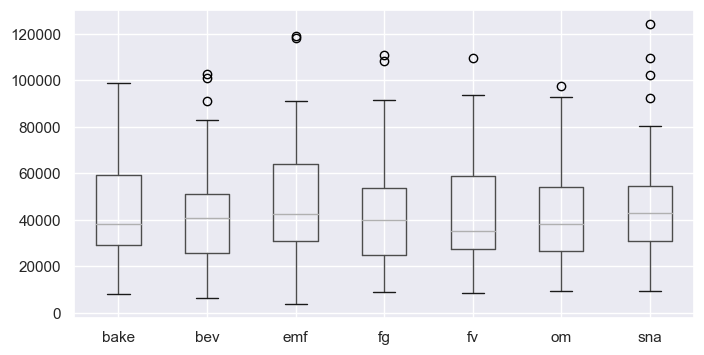

In [5]:
#Avaliação de outliers

numeric_col = ['bake','bev','emf', 'fg','fv','om', 'sna']
categorical_col = ['date']
df_sum.boxplot(numeric_col)

In [6]:
#Verificação de estrutura do dataframe

df_sum2 = df_sum.set_index('date')

df_sum2.shape

(48, 8)

## 4.ADF Test

In [7]:
# ADF Test

datasets = {
    'Bakery': df_sum.bake,
    'Beverages': df_sum.bev,
    'Eggs, Meat & Fish': df_sum.emf,
    'Food Grains': df_sum.fg,
    'Fruits & Veggies': df_sum.fv,
    'Oil & Masala': df_sum.om,
    'Snacks': df_sum.sna,
    'Total': df_sum.total,
}

def adf_dataframe(datasets):
   
    resultados = pd.DataFrame(columns=['Dataset', 'Estatistica ADF', 'p_valor', 'Lags', 'Valores Criticos'])
    
    for dataset_name, dataset in datasets.items():
        resultado_adf = adfuller(dataset)
        estatistica_adf = resultado_adf[0]
        p_valor = resultado_adf[1]
        lags = resultado_adf[2]
        valores_criticos = resultado_adf[4]
        resultados = resultados.append({
            'Dataset': dataset_name,
            'Estatistica ADF': estatistica_adf,
            'p_valor': p_valor,
            'Lags': lags,
            'Valores Criticos': valores_criticos
        }, ignore_index=True)
    return resultados


df_adftest = adf_dataframe(datasets)

df_adftest

#df_adftest.to_excel('G:/Meu Drive/MBA USPEsalq/TCC/07.Trabalho Final/teste adf.xlsx', index=False)

,Dataset,Estatistica ADF,p_valor,Lags,Valores Criticos
0,Bakery,-4.025953,0.001281,0,"{'1%': -3.5778480370438146, '5%': -2.925338105..."
1,Beverages,-3.554054,0.006703,0,"{'1%': -3.5778480370438146, '5%': -2.925338105..."
2,"Eggs, Meat & Fish",-3.860622,0.002345,0,"{'1%': -3.5778480370438146, '5%': -2.925338105..."
3,Food Grains,-3.775124,0.003172,0,"{'1%': -3.5778480370438146, '5%': -2.925338105..."
4,Fruits & Veggies,-3.716338,0.003889,0,"{'1%': -3.5778480370438146, '5%': -2.925338105..."
5,Oil & Masala,-3.988121,0.001474,0,"{'1%': -3.5778480370438146, '5%': -2.925338105..."
6,Snacks,-1.468981,0.548797,2,"{'1%': -3.584828853223594, '5%': -2.9282991495..."
7,Total,-3.641394,0.005017,0,"{'1%': -3.5778480370438146, '5%': -2.925338105..."


## 5.Separando os dados (train / test)

In [8]:
#Slice dataframe train & test

X_train = df_sum[df_sum['date'] < '2018-01-01']
X_test = df_sum[df_sum['date'] >= '2018-01-01']

print('X_train Shape', X_train.shape)
print('X_test Shape', X_test.shape)

period_test = X_test['date'].nunique() + 1

period_test_date = X_test['date'].unique()
start = pd.to_datetime(period_test_date[0])
end = pd.to_datetime(period_test_date[len(period_test_date)-1])

X_test['date'].unique()

X_train Shape (36, 9)
X_test Shape (12, 9)


array(['2018-01-01T00:00:00.000000000', '2018-02-01T00:00:00.000000000',
       '2018-03-01T00:00:00.000000000', '2018-04-01T00:00:00.000000000',
       '2018-05-01T00:00:00.000000000', '2018-06-01T00:00:00.000000000',
       '2018-07-01T00:00:00.000000000', '2018-08-01T00:00:00.000000000',
       '2018-09-01T00:00:00.000000000', '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [9]:
## Preparação de base para treino e teste

# Filtrando categoria na base de treino
df_total_train = X_train[['date','total']]

# Filtrando categoria na base de teste
df_total_test = X_test[['date','total']]

# Configurando a coluna de data como index
df_total_train.set_index('date', inplace=True)
df_total_test.set_index('date', inplace=True)

# Configurando o Index para período de teste

index_dates = pd.date_range(df_total_train.index[-1], freq='MS', periods = period_test) 
index_dates = index_dates.delete(0)

## 6.ARIMA (Autoregressive Integrated Moving Average)

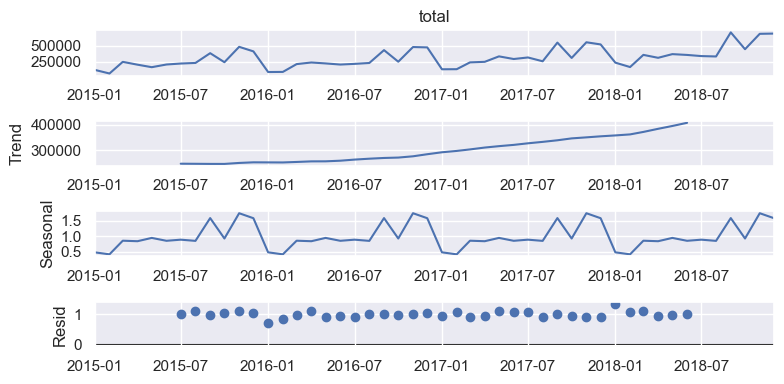

In [10]:
#Deconposição do dataset

result_total= seasonal_decompose(df_sum2['total'], model='multiplicative')
result_total.plot();

In [11]:
#Encontrando melhor modelo auto_arima

auto_arima_model_total = auto_arima(df_total_train['total'],
                               seasonal = True,
                                m = 12,
                               start_p = 0, 
                               d = 1, 
                               start_q = 0,
                               max_p = 3,
                               max_q = 3,
                                D = 1,
                                start_P = 0,
                                start_Q = 0,
                                max_P = 3,
                                max_Q = 3,
                                information_criterion = 'aic',
                                error_action = 'warn',
                                trace = True,
                                suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=566.077, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=561.824, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=565.265, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=559.841, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=561.825, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=560.619, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=560.956, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=563.266, Time=0.04 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=564.900, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=562.036, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.943 seconds


In [12]:
# Rodando ARIMA com base em melhor modelo pelo auto_arima
model_auto_arima_total = SARIMAX(df_total_train, order=auto_arima_model_total.order, seasonal_order = auto_arima_model_total.seasonal_order)
model_auto_arima_fit_total = model_auto_arima_total.fit()

# Salvando predições ARIMA
fcast_total_arima = model_auto_arima_fit_total.forecast(period_test-1)

fcast_total_auto_arima = pd.Series(fcast_total_arima.values, index=index_dates)

fcast_total_auto_arima = pd.Series(fcast_total_arima.values, index=index_dates)
fcast_total_auto_arima = fcast_total_auto_arima.rename("fcst_auto_arima")

rmse_auto_arima = np.sqrt(mean_squared_error(df_total_test['total'], fcast_total_auto_arima))
mape_auto_arima = mean_absolute_percentage_error(df_total_test['total'], fcast_total_auto_arima)*100
resid_mean_auto_arima = model_auto_arima_fit_total.resid.mean()

print(rmse_auto_arima)
print(mape_auto_arima)
print(resid_mean_auto_arima)

63489.06047113921
11.788982860942731
1731.0343636637638


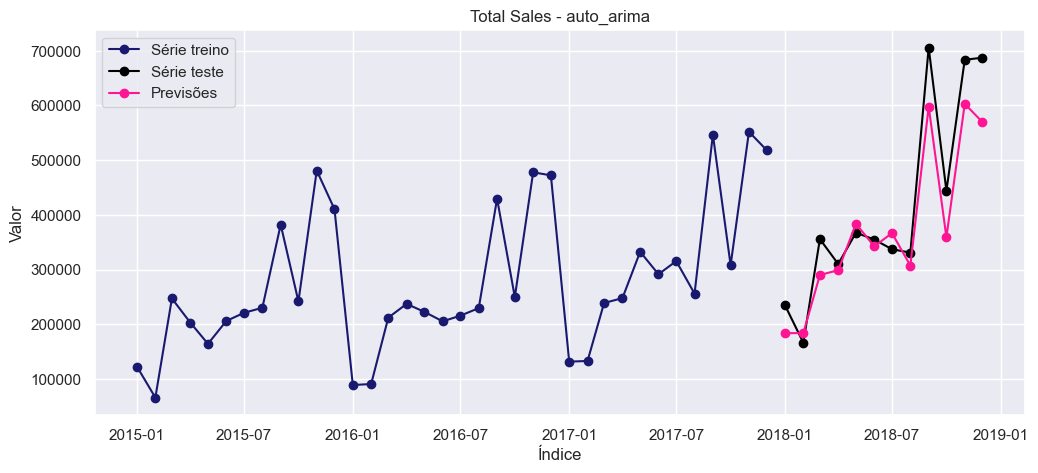

In [13]:
# Plotando previsões auto-arima
fig, ax = plt.subplots(figsize=(12,5))

plt.plot(df_total_train, label='Série treino', color='midnightblue', marker='o')
plt.plot(df_total_test, label='Série teste', color='black', marker='o')
plt.plot(fcast_total_auto_arima, label='Previsões', color='deeppink', marker='o')

# Adicione legendas e títulos ao gráfico
plt.plot(marker='o')
ax.legend(loc='upper left')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Total Sales - auto_arima')

# Mostre o gráfico
plt.show()

In [14]:
#Função para encontrar o modelo ARIMA

def evaluate_arima_model(df, order, seasonal_order):

    model = SARIMAX(df, order=order, seasonal_order=seasonal_order)
    results = model.fit()

    # Calcula algumas métricas de avaliação do modelo
    aic = results.aic
    resid_mean = results.resid.mean()

    return {'order': order, 'seasonal_order': seasonal_order, 'aic': aic, 'resid_mean': resid_mean}


def evaluate_models(df, seasonal=True):

    # Define as listas de parâmetros para a busca
    p = range(0, 3)
    d = range(1, 2)
    q = range(0, 3)
    P = range(0, 3)
    D = range(1, 2)
    Q = range(0, 3)
    m = range(12,13)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq  = list(itertools.product(P, D, Q,m))    

    all_models = []

    # Itera por todas as combinações de parâmetros
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            model_params = evaluate_arima_model(df, param, param_seasonal)
            if model_params:
                all_models.append(model_params)

    # Converte a lista de resultados em um DataFrame pandas
    all_models_df = pd.DataFrame(all_models)

    # Define o número de períodos de validação
    n_periods = 12

    # Calcula as métricas RMSE e MAPE para cada modelo
    rmse_list = []
    mape_list = []
    
    for i in range(len(all_models)):
        model = SARIMAX(df, order=all_models[i]['order'], seasonal_order=all_models[i]['seasonal_order'])
        results = model.fit()
        preds = results.forecast(steps=n_periods)
        rmse = np.sqrt(mean_squared_error(df_total_test['total'], preds))
        mape = mean_absolute_percentage_error(df_total_test['total'], preds)*100
        rmse_list.append(rmse)
        mape_list.append(mape)

    # Adiciona as colunas de RMSE e MAPE ao DataFrame
    all_models_df['rmse'] = rmse_list
    all_models_df['mape'] = mape_list

    # Retorna o DataFrame com os resultados de todos os modelos avaliados
    return all_models_df

In [15]:
# Chama a função evaluate_models para obter uma tabela com todos os modelos avaliados
df_models = evaluate_models(df_total_train, seasonal=True)

df_models.to_excel('G:/Meu Drive/MBA USPEsalq/TCC/07.Trabalho Final/modelos.xlsx', index=False)

df_models

,order,seasonal_order,aic,resid_mean,rmse,mape
0,"(0, 1, 0)","(0, 1, 0, 12)",566.077011,1281.780738,66929.168471,12.302582
1,"(0, 1, 0)","(0, 1, 1, 12)",565.406024,1275.257196,66931.405660,12.314818
2,"(0, 1, 0)","(0, 1, 2, 12)",566.461911,-123.320199,106052.900796,23.179888
3,"(0, 1, 0)","(1, 1, 0, 12)",565.393758,1274.395051,66935.178077,12.316591
4,"(0, 1, 0)","(1, 1, 1, 12)",567.008296,685.067140,69186.376909,12.865344
...,...,...,...,...,...,...
76,"(2, 1, 2)","(1, 1, 1, 12)",566.174631,1973.685535,50803.155706,10.006614
77,"(2, 1, 2)","(1, 1, 2, 12)",568.165856,2139.437196,49578.426562,10.003826
78,"(2, 1, 2)","(2, 1, 0, 12)",566.164603,2130.799971,49485.056068,10.001116
79,"(2, 1, 2)","(2, 1, 1, 12)",568.167204,2108.116039,49701.967918,10.005847


In [16]:
#Filtrando melhores modelos

df_models_index = df_models.reset_index()

query = [80,72, 74,78]

df_models_filtered = df_models_index[df_models_index['index'].isin(query)]

df_models_filtered = df_models_filtered.reset_index()

df_models_filtered.to_excel('G:/Meu Drive/MBA USPEsalq/TCC/07.Trabalho Final/melhores modelos.xlsx', index=False)

df_models_filtered

,level_0,index,order,seasonal_order,aic,resid_mean,rmse,mape
0,72,72,"(2, 1, 2)","(0, 1, 0, 12)",562.266482,1836.145576,50247.356408,9.968148
1,74,74,"(2, 1, 2)","(0, 1, 2, 12)",566.162898,2142.875108,49316.537966,10.013344
2,78,78,"(2, 1, 2)","(2, 1, 0, 12)",566.164603,2130.799971,49485.056068,10.001116
3,80,80,"(2, 1, 2)","(2, 1, 2, 12)",570.059981,2145.926159,46561.794449,9.775444


In [17]:
#Salvando parâmetros dos melhores modelos selecionados

order_model1 = df_models_filtered['order'].loc[0]
seasonal_order_model1 = df_models_filtered['seasonal_order'].loc[0]

order_model2 = df_models_filtered['order'].loc[1]
seasonal_order_model2 = df_models_filtered['seasonal_order'].loc[1]

order_model3 = df_models_filtered['order'].loc[2]
seasonal_order_model3 = df_models_filtered['seasonal_order'].loc[2]

order_model4 = df_models_filtered['order'].loc[3]
seasonal_order_model4 = df_models_filtered['seasonal_order'].loc[3]

In [18]:
# Rodando ARIMA com base em melhor modelo pela função best_model 1

model_best_model_total1 = SARIMAX(df_total_train, order=order_model1, seasonal_order = seasonal_order_model1)
model_best_model_fit_total1 = model_best_model_total1.fit()

# Salvando predições ARIMA
fcast_total_best_model1 = model_best_model_fit_total1.forecast(period_test-1)

fcast_total_best_model1 = pd.Series(fcast_total_best_model1.values, index=index_dates)

fcast_total_best_model1 = pd.Series(fcast_total_best_model1.values, index=index_dates)
fcast_total_best_model1 = fcast_total_best_model1.rename("fcst_best_model1")


# Rodando ARIMA com base em melhor modelo pela função best_model 2

model_best_model_total2 = SARIMAX(df_total_train, order=order_model2, seasonal_order = seasonal_order_model2)
model_best_model_fit_total2 = model_best_model_total2.fit()

# Salvando predições ARIMA
fcast_total_best_model2 = model_best_model_fit_total2.forecast(period_test-1)

fcast_total_best_model2 = pd.Series(fcast_total_best_model2.values, index=index_dates)

fcast_total_best_model2 = pd.Series(fcast_total_best_model2.values, index=index_dates)
fcast_total_best_model2 = fcast_total_best_model2.rename("fcst_best_model2")

# Rodando ARIMA com base em melhor modelo pela função best_model 3

model_best_model_total3 = SARIMAX(df_total_train, order=order_model3, seasonal_order = seasonal_order_model3)
model_best_model_fit_total3 = model_best_model_total3.fit()

# Salvando predições ARIMA
fcast_total_best_model3 = model_best_model_fit_total3.forecast(period_test-1)

fcast_total_best_model3 = pd.Series(fcast_total_best_model3.values, index=index_dates)

fcast_total_best_model3 = pd.Series(fcast_total_best_model3.values, index=index_dates)
fcast_total_best_model3 = fcast_total_best_model3.rename("fcst_best_model3")

# Rodando ARIMA com base em melhor modelo pela função best_model 4

model_best_model_total4 = SARIMAX(df_total_train, order=order_model4, seasonal_order = seasonal_order_model4)
model_best_model_fit_total4 = model_best_model_total4.fit()

# Salvando predições ARIMA
fcast_total_best_model4 = model_best_model_fit_total4.forecast(period_test-1)

fcast_total_best_model4 = pd.Series(fcast_total_best_model4.values, index=index_dates)

fcast_total_best_model4 = pd.Series(fcast_total_best_model4.values, index=index_dates)
fcast_total_best_model4 = fcast_total_best_model4.rename("fcst_best_model4")

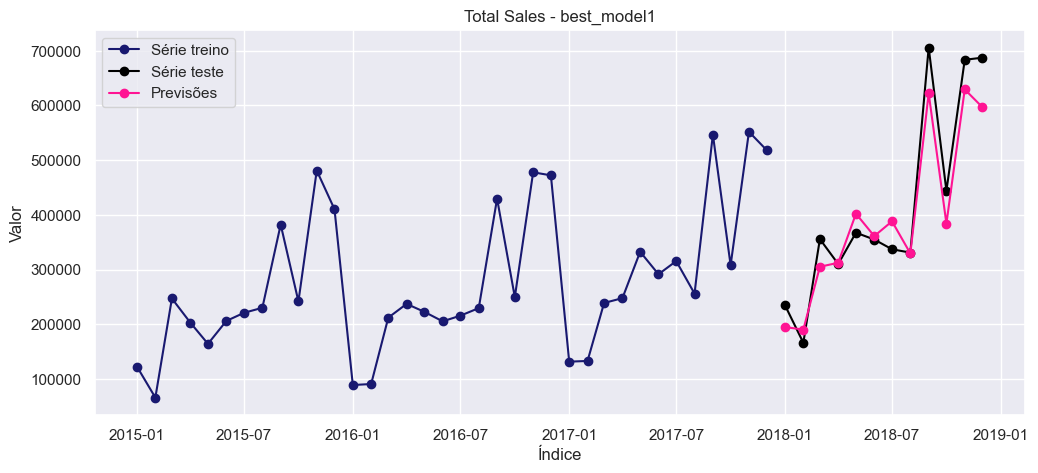

In [19]:
# Plotando previsões best_model1
fig, ax = plt.subplots(figsize=(12,5))

plt.plot(df_total_train, label='Série treino', color='midnightblue', marker='o')
plt.plot(df_total_test, label='Série teste', color='black', marker='o')
plt.plot(fcast_total_best_model1, label='Previsões', color='deeppink', marker='o')

# Adicione legendas e títulos ao gráfico
plt.plot(marker='o')
ax.legend(loc='upper left')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Total Sales - best_model1')

# Mostre o gráfico
plt.show()

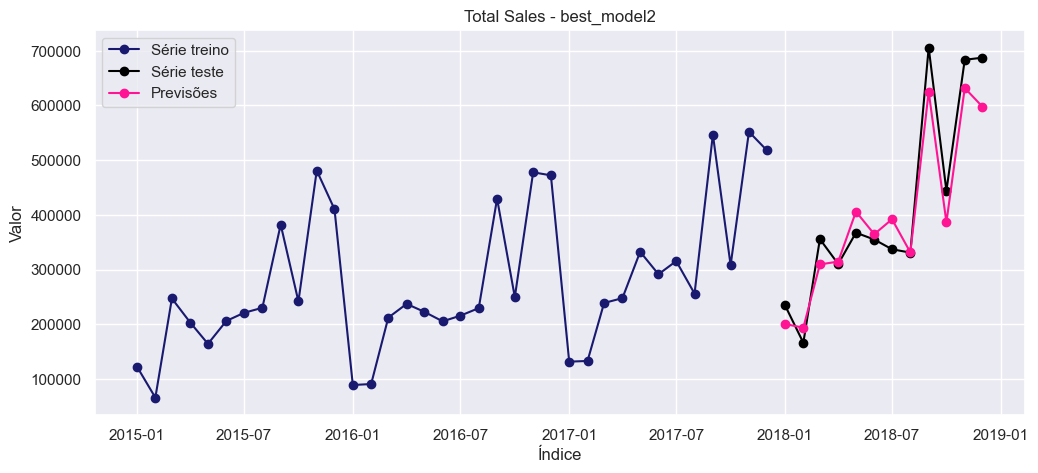

In [20]:
# Plotando previsões best_model2
fig, ax = plt.subplots(figsize=(12,5))

plt.plot(df_total_train, label='Série treino', color='midnightblue', marker='o')
plt.plot(df_total_test, label='Série teste', color='black', marker='o')
plt.plot(fcast_total_best_model2, label='Previsões', color='deeppink', marker='o')

# Adicione legendas e títulos ao gráfico
plt.plot(marker='o')
ax.legend(loc='upper left')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Total Sales - best_model2')

# Mostre o gráfico
plt.show()

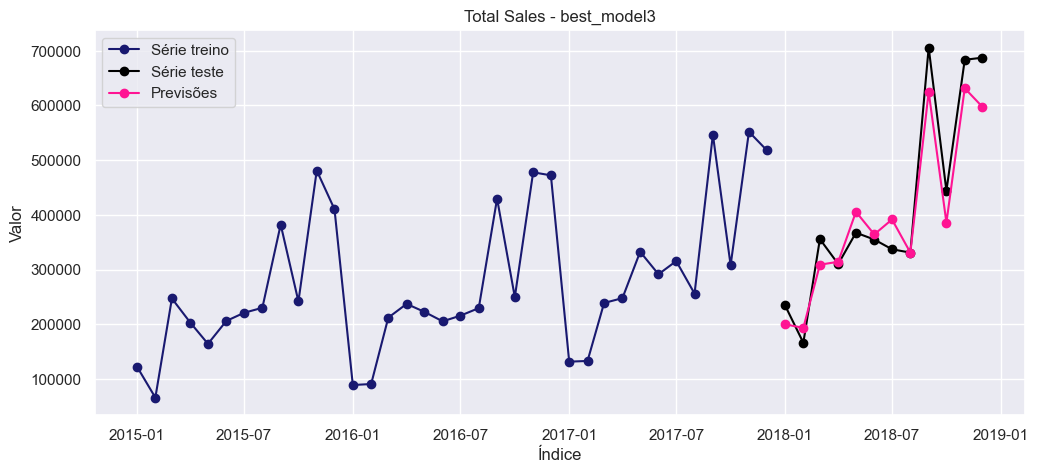

In [21]:
# Plotando previsões best_model3
fig, ax = plt.subplots(figsize=(12,5))

plt.plot(df_total_train, label='Série treino', color='midnightblue', marker='o')
plt.plot(df_total_test, label='Série teste', color='black', marker='o')
plt.plot(fcast_total_best_model3, label='Previsões', color='deeppink', marker='o')

# Adicione legendas e títulos ao gráfico
plt.plot(marker='o')
ax.legend(loc='upper left')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Total Sales - best_model3')

# Mostre o gráfico
plt.show()

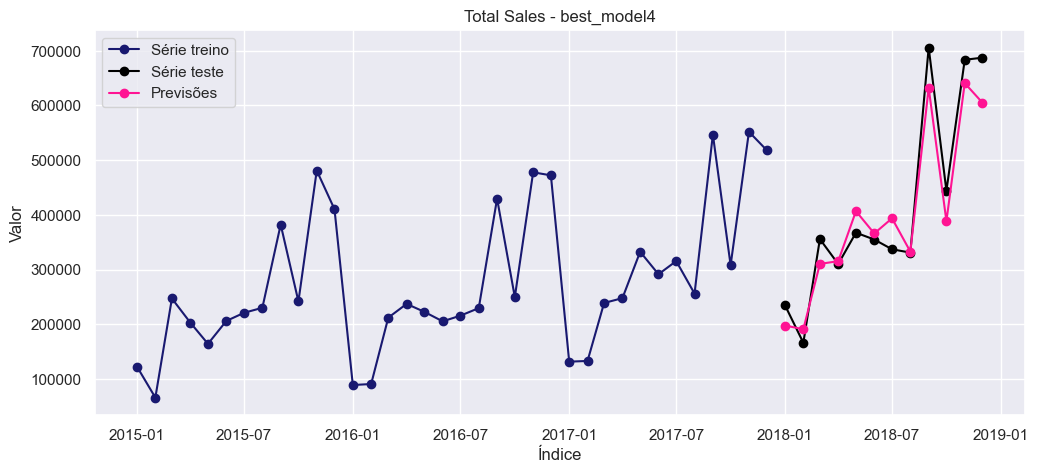

In [22]:
# Plotando previsões best_model4
fig, ax = plt.subplots(figsize=(12,5))

plt.plot(df_total_train, label='Série treino', color='midnightblue', marker='o')
plt.plot(df_total_test, label='Série teste', color='black', marker='o')
plt.plot(fcast_total_best_model4, label='Previsões', color='deeppink', marker='o')

# Adicione legendas e títulos ao gráfico
plt.plot(marker='o')
ax.legend(loc='upper left')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Total Sales - best_model4')

# Mostre o gráfico
plt.show()

In [23]:
#Preparando dados para fazer merge de Actual + Previsões para o período de testes

##Preparando Actual

actual_total = df_total_test['total'].values
df_actual_total = pd.DataFrame(actual_total)

##Preparando Previsões

df_fcast_auto_arima_total = pd.DataFrame(fcast_total_auto_arima).reset_index()
df_fcast_best_model1_total = pd.DataFrame(fcast_total_best_model1).reset_index()
df_fcast_best_model2_total = pd.DataFrame(fcast_total_best_model2).reset_index()
df_fcast_best_model3_total = pd.DataFrame(fcast_total_best_model3).reset_index()
df_fcast_best_model4_total = pd.DataFrame(fcast_total_best_model4).reset_index()

#Fazendo merge dos dataframes

df_tt_total = pd.merge(df_actual_total,
                       df_fcast_auto_arima_total,
                       left_index=True, 
                       right_index=True)

df_concat = pd.concat([df_tt_total, 
                       df_fcast_best_model1_total, 
                       df_fcast_best_model2_total, 
                       df_fcast_best_model3_total, 
                       df_fcast_best_model4_total], axis=1)

df_tt_total = df_concat.iloc[:, [1, 0,2,4,6,8,10]]

df_tt_total.rename(columns={'index': 'date',0: 'actual'}, inplace = True) 

In [24]:
#Preparando dados para montar tabela comparativa de estatísticas mmedidodas de desempenho

actual_test = df_tt_total['actual']
fcst_auto_arima = df_tt_total['fcst_auto_arima']
fcst_best_model1 = df_tt_total['fcst_best_model1']
fcst_best_model2 = df_tt_total['fcst_best_model2']
fcst_best_model3 = df_tt_total['fcst_best_model3']
fcst_best_model4 = df_tt_total['fcst_best_model4']

mape_auto_arima = mean_absolute_percentage_error(actual_test, fcst_auto_arima)*100
mape_fcst_best_model1 = mean_absolute_percentage_error(actual_test, fcst_best_model1)*100
mape_fcst_best_model2 = mean_absolute_percentage_error(actual_test, fcst_best_model2)*100
mape_fcst_best_model3 = mean_absolute_percentage_error(actual_test, fcst_best_model3)*100
mape_fcst_best_model4 = mean_absolute_percentage_error(actual_test, fcst_best_model4)*100

resid_auto_arima = model_auto_arima_fit_total.resid.mean()
resid_fcst_best_model1 = df_models_filtered['resid_mean'].loc[0]
resid_fcst_best_model2 = df_models_filtered['resid_mean'].loc[1]
resid_fcst_best_model3 = df_models_filtered['resid_mean'].loc[2]
resid_fcst_best_model4 = df_models_filtered['resid_mean'].loc[3]

aic_auto_arima = auto_arima_model_total.aic()
aic_fcst_best_model1 = df_models_filtered['aic'].loc[0]
aic_fcst_best_model2 = df_models_filtered['aic'].loc[1]
aic_fcst_best_model3 = df_models_filtered['aic'].loc[2]
aic_fcst_best_model4 = df_models_filtered['aic'].loc[3]

#Teste t para verificar se a média dos resísuos é igual a zero estatisticamente 

## acima do nível de significância de 5% aceita H0, não há evidência que a média da amostra seja diferente de Zero

model_auto_arima_resid = model_auto_arima_fit_total.resid
model_best_model_total1_resid = model_best_model_fit_total1.resid
model_best_model_total2_resid = model_best_model_fit_total2.resid
model_best_model_total3_resid = model_best_model_fit_total3.resid
model_best_model_total4_resid = model_best_model_fit_total4.resid


t_pvalue_auto_arima = stats.ttest_1samp(model_auto_arima_resid, 0).pvalue
t_pvalue_best_model_total1_resid = stats.ttest_1samp(model_best_model_total1_resid, popmean=0).pvalue
t_pvalue_best_model_total2_resid = stats.ttest_1samp(model_best_model_total2_resid, popmean=0).pvalue
t_pvalue_best_model_total3_resid = stats.ttest_1samp(model_best_model_total3_resid, popmean=0).pvalue
t_pvalue_best_model_total4_resid = stats.ttest_1samp(model_best_model_total4_resid, popmean=0).pvalue

#Teste de autocorrelação Ljung & Box para analisar o impacto dos resíduos

## acima do nível de significância de 5% aceita H0, não há evidência estatística para sugerir que 
## há autocorrelação nos resíduos do modelo de séries temporais em diferentes defasagens

ljungbox_test_auto_arima = acorr_ljungbox(model_auto_arima_resid, lags=[12], return_df=True)
ljungbox_test_best_model_total1 = acorr_ljungbox(model_best_model_total1_resid, lags=[12], return_df=True)
ljungbox_test_best_model_total2 = acorr_ljungbox(model_best_model_total2_resid, lags=[12], return_df=True)
ljungbox_test_best_model_total3 = acorr_ljungbox(model_best_model_total3_resid, lags=[12], return_df=True)
ljungbox_test_best_model_total4 = acorr_ljungbox(model_best_model_total4_resid, lags=[12], return_df=True)

ljungbox_test_auto_arima_pvalue = ljungbox_test_auto_arima.lb_pvalue[12]*100
ljungbox_test_best_model_total1_pvalue = ljungbox_test_best_model_total1.lb_pvalue[12]*100
ljungbox_test_best_model_total2_pvalue = ljungbox_test_best_model_total2.lb_pvalue[12]*100
ljungbox_test_best_model_total3_pvalue = ljungbox_test_best_model_total3.lb_pvalue[12]*100
ljungbox_test_best_model_total4_pvalue = ljungbox_test_best_model_total4.lb_pvalue[12]*100


#Criando objeto com listas de dados para criar dataframe único

obj = {'modelos': ['auto_arima', 
                           'best_model1',
                           'best_model2',
                           'best_model3', 
                           'best_model4'], 
       'actual': [actual_test.sum(),
                  actual_test.sum(),
                  actual_test.sum(),
                  actual_test.sum(),
                  actual_test.sum()],                       
       'forecast': [fcst_auto_arima.sum(),
                    fcst_best_model1.sum(),
                    fcst_best_model2.sum(),
                    fcst_best_model3.sum(),
                    fcst_best_model4.sum()],
        'aic': [aic_auto_arima,
              aic_fcst_best_model1,             
              aic_fcst_best_model2,             
              aic_fcst_best_model3,
               aic_fcst_best_model4],
      'mape': [mape_auto_arima,
               mape_fcst_best_model1,                           
                mape_fcst_best_model2,
               mape_fcst_best_model3,
               mape_fcst_best_model4],              
      'residuos': [resid_auto_arima,
                   resid_fcst_best_model1,
                   resid_fcst_best_model2, 
                   resid_fcst_best_model3, 
                   resid_fcst_best_model4],
       'teste_t': [t_pvalue_auto_arima,
                   t_pvalue_best_model_total1_resid,
                   t_pvalue_best_model_total2_resid, 
                   t_pvalue_best_model_total3_resid,
                   t_pvalue_best_model_total4_resid],
       'ljungbox_test': [ljungbox_test_auto_arima_pvalue,
                   ljungbox_test_best_model_total1_pvalue,
                   ljungbox_test_best_model_total2_pvalue, 
                   ljungbox_test_best_model_total3_pvalue,
                   ljungbox_test_best_model_total4_pvalue]}

#Criando dataframe único

df_metricas = pd.DataFrame(data=obj, dtype=float)

df_metricas['actual'] = df_metricas['actual'].apply(lambda x: '%0.2f' % x)
df_metricas['forecast'] = df_metricas['forecast'].apply(lambda x: '%0.2f' % x)
df_metricas['mape'] = df_metricas['mape'].apply(lambda x: '%0.2f' % x)
df_metricas['residuos'] = df_metricas['residuos'].apply(lambda x: '%0.2f' % x)
df_metricas['teste_t'] = df_metricas['teste_t'].apply(lambda x: '%0.2f' % x)
df_metricas['ljungbox_test'] = df_metricas['ljungbox_test'].apply(lambda x: '%0.2f' % x)
df_metricas['aic'] = df_metricas['aic'].apply(lambda x: '%0.2f' % x)

df_metricas.to_excel('G:/Meu Drive/MBA USPEsalq/TCC/07.Trabalho Final/metricas modelos arima.xlsx', index=False)

df_metricas

,modelos,actual,forecast,aic,mape,residuos,teste_t,ljungbox_test
0,auto_arima,4977512.00,4485890.85,559.84,11.79,1731.03,0.92,73.07
1,best_model1,4977512.00,4715818.31,562.27,9.97,1836.15,0.92,56.67
2,best_model2,4977512.00,4753169.26,566.16,10.01,2142.88,0.90,52.65
3,best_model3,4977512.00,4748340.70,566.16,10.00,2130.80,0.90,52.71
4,best_model4,4977512.00,4779897.79,570.06,9.78,2145.93,0.90,50.65


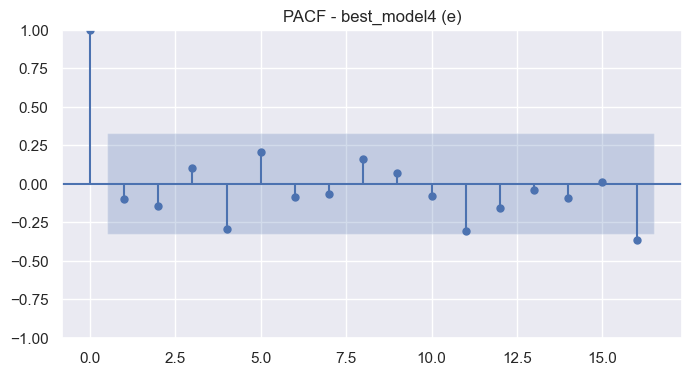

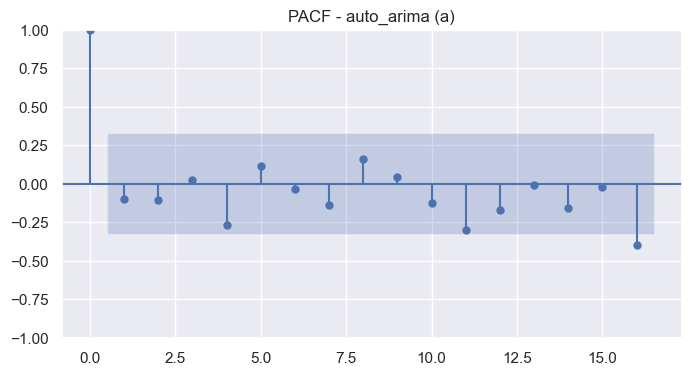

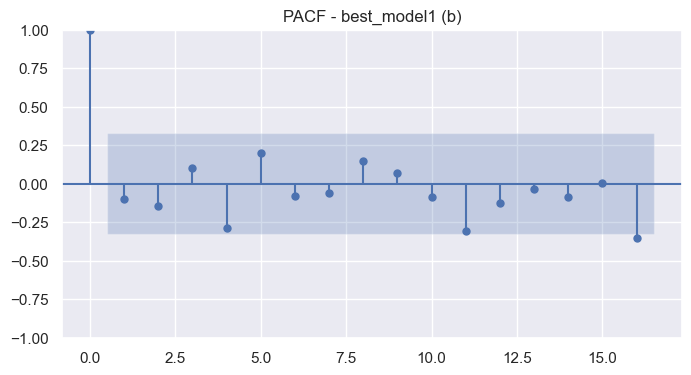

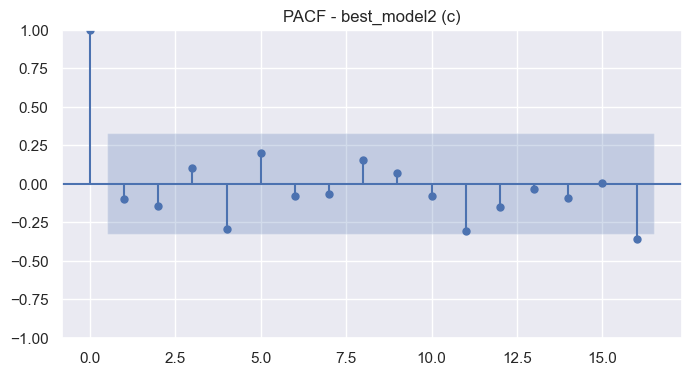

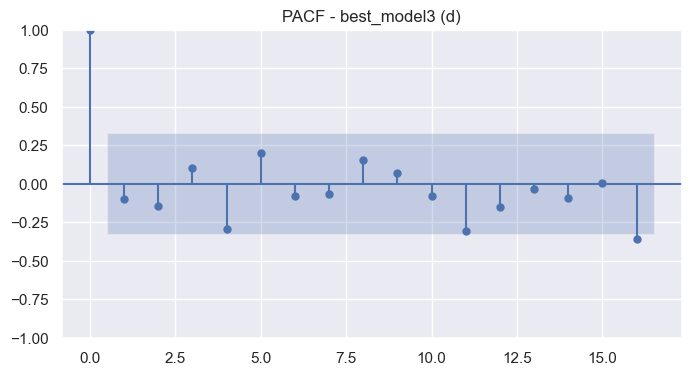

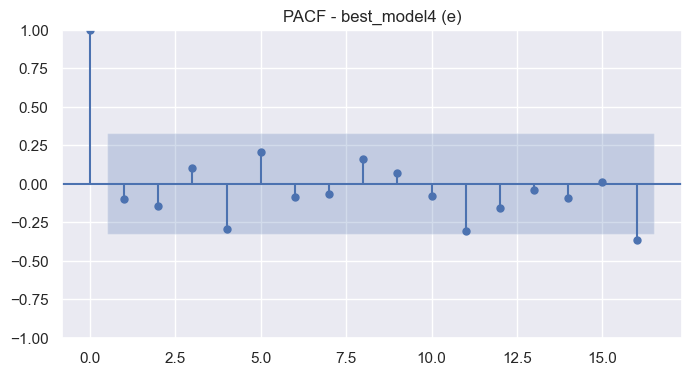

In [25]:
# PACF dos resíduos para entendimento do padrão de dados

plot_pacf(model_auto_arima_resid, title = "PACF - auto_arima (a)", alpha=.05)

plot_pacf(model_best_model_total1_resid, title = "PACF - best_model1 (b)", alpha=.05)

plot_pacf(model_best_model_total2_resid, title = "PACF - best_model2 (c)", alpha=.05)

plot_pacf(model_best_model_total3_resid, title = "PACF - best_model3 (d)", alpha=.05)

plot_pacf(model_best_model_total4_resid, title = "PACF - best_model4 (e)", alpha=.05)


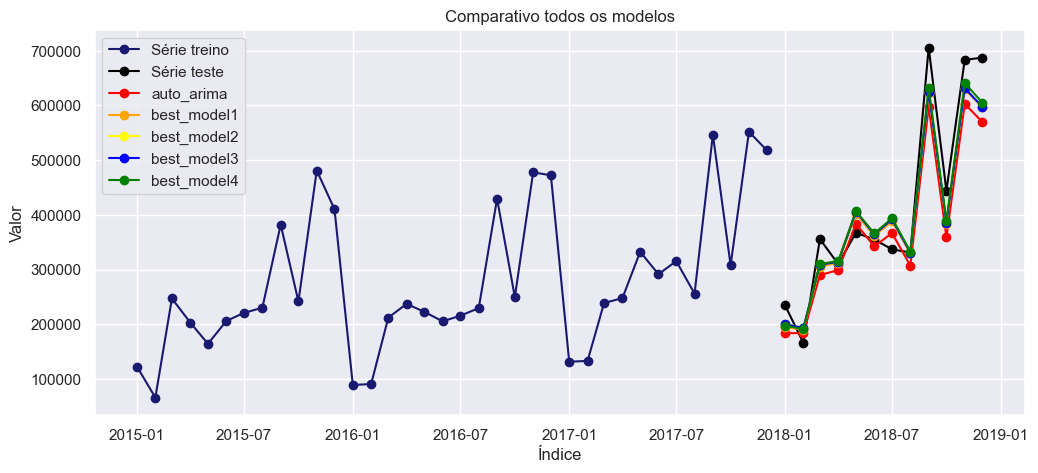

In [26]:
# Plotando previsões best_model4
fig, ax = plt.subplots(figsize=(12,5))

plt.plot(df_total_train, label='Série treino', color='midnightblue', marker='o')
plt.plot(df_total_test, label='Série teste', color='black', marker='o')
plt.plot(fcast_total_auto_arima, label='auto_arima', color='red', marker='o')
plt.plot(fcast_total_best_model1, label='best_model1', color='orange', marker='o')
plt.plot(fcast_total_best_model2, label='best_model2', color='yellow', marker='o')
plt.plot(fcast_total_best_model3, label='best_model3', color='blue', marker='o')
plt.plot(fcast_total_best_model4, label='best_model4', color='green', marker='o')

# Adicione legendas e títulos ao gráfico
plt.plot(marker='o')
ax.legend(loc='upper left')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Comparativo todos os modelos')

# Mostre o gráfico
plt.show()

## 7.neuralprophet

In [27]:
########################################################################################################
####################################### Rodando neuralprophet para Total ###############################
########################################################################################################

# Setando datas

index_dates2 = pd.DataFrame(index_dates)
index_dates2.columns = ['ds']
index_dates2['y'] = 0

# Usando o modelo para realizar previsões

df_total_train2 = df_total_train.copy().reset_index()
df_total_train2 = df_total_train2[['date', 'total']]
df_total_train2.columns = ['ds', 'y']
df_total_train2['ds']= to_datetime(df_total_train2['ds'])

# Definindo o modelo
n_prophet_total = NeuralProphet()

# Configurando o modelo
n_prophet_total.fit(df_total_train2)

fcast_total_np = n_prophet_total.predict(index_dates2)

fcast_total_np = pd.DataFrame(fcast_total_np)
fcast_total_np = fcast_total_np[['ds', 'yhat1']]
fcast_total_np.set_index('ds', inplace=True)

pred_total_np = fcast_total_np.values

# Verificando RMSE/MAPE

print('The RMSE of prophet is:',mean_squared_error(df_total_test['total'].values, fcast_total_np.values, squared=False))
print('The MAPE of prophet is:',mean_absolute_percentage_error(actual_test, pred_total_np)*100)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 88.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 1000
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (3) is too small than the required number for the learning rate finder (203). The results 

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 83.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 83.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 3it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


The RMSE of prophet is: 50662.44028913
The MAPE of prophet is: 9.772424854133266


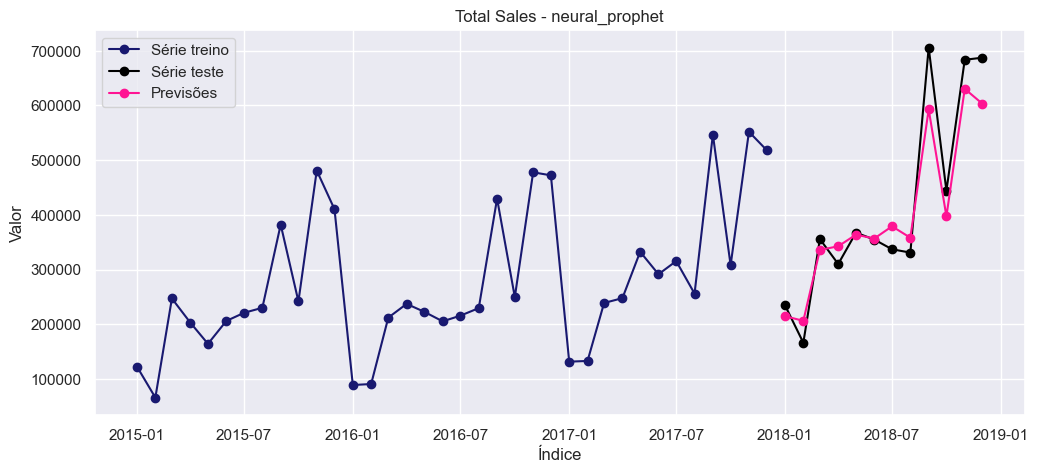

In [28]:
# Plotando previsões best_model4

fig, ax = plt.subplots(figsize=(12,5))

plt.plot(df_total_train, label='Série treino', color='midnightblue', marker='o')
plt.plot(df_total_test, label='Série teste', color='black', marker='o')
plt.plot(fcast_total_np, label='Previsões', color='deeppink', marker='o')

# Adicione legendas e títulos ao gráfico
plt.plot(marker='o')
ax.legend(loc='upper left')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Total Sales - neural_prophet')

# Mostre o gráfico
plt.show()

# 8. Fit por categoria

## Bakery

In [29]:
## Preparação de base para treino e teste

# Filtrando categoria na base de treino
df_bake_train = X_train[['date','bake']]

# Filtrando categoria na base de teste
df_bake_test = X_test[['date','bake']]

# Configurando a coluna de data como index
df_bake_train.set_index('date', inplace=True)
df_bake_test.set_index('date', inplace=True)


In [30]:
#Encontrando melhor modelo auto_arima

auto_arima_model_bake = auto_arima(df_bake_train['bake'],
                               seasonal = True,
                                m = 12,
                               start_p = 0, 
                               d = 1, 
                               start_q = 0,
                               max_p = 3,
                               max_q = 3,
                                D = 1,
                                start_P = 0,
                                start_Q = 0,
                                max_P = 3,
                                max_Q = 3,
                                information_criterion = 'aic',
                                error_action = 'warn',
                                trace = True,
                                suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=494.227, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=494.237, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=493.522, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=494.148, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=494.591, Time=0.24 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=495.368, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=495.911, Time=0.82 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=495.621, Time=0.04 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=498.727, Time=0.10 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=501.558, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=494.280, Time=0.11 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=503.226, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=497.461, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]

In [31]:
# Rodando ARIMA com base em melhor modelo pelo auto_arima
model_auto_arima_bake = SARIMAX(df_bake_train, order=auto_arima_model_bake.order, seasonal_order = auto_arima_model_bake.seasonal_order)
model_auto_arima_fit_bake = model_auto_arima_bake.fit()

# Salvando predições ARIMA
fcast_bake_arima = model_auto_arima_fit_bake.forecast(period_test-1)

fcast_bake_auto_arima = pd.Series(fcast_bake_arima.values, index=index_dates)

fcast_bake_auto_arima = pd.Series(fcast_bake_arima.values, index=index_dates)
fcast_bake_auto_arima = fcast_bake_auto_arima.rename("fcst_auto_arima")

rmse_auto_arima_bake = np.sqrt(mean_squared_error(df_bake_test['bake'], fcast_bake_auto_arima))
mape_auto_arima_bake = mean_absolute_percentage_error(df_bake_test['bake'], fcast_bake_auto_arima)*100
resid_mean_auto_arima_bake = model_auto_arima_fit_bake.resid.mean()

print(rmse_auto_arima_bake)
print(mape_auto_arima_bake)
print(resid_mean_auto_arima_bake)

13735.635213982796
19.059978279819408
194.8280373921429


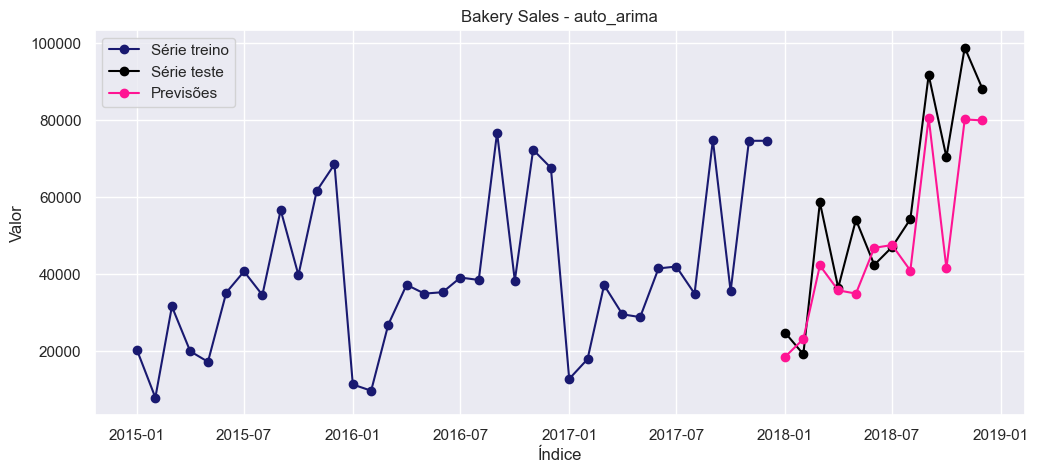

In [32]:
# Plotando previsões auto-arima
fig, ax = plt.subplots(figsize=(12,5))

plt.plot(df_bake_train, label='Série treino', color='midnightblue', marker='o')
plt.plot(df_bake_test, label='Série teste', color='black', marker='o')
plt.plot(fcast_bake_auto_arima, label='Previsões', color='deeppink', marker='o')

# Adicione legendas e títulos ao gráfico
plt.plot(marker='o')
ax.legend(loc='upper left')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Bakery Sales - auto_arima')

# Mostre o gráfico
plt.show()

In [33]:
#Função para encontrar o modelo ARIMA

def evaluate_arima_model(df, order, seasonal_order):

    model = SARIMAX(df, order=order, seasonal_order=seasonal_order)
    results = model.fit()

    # Calcula algumas métricas de avaliação do modelo
    aic = results.aic
    resid_mean = results.resid.mean()

    return {'order': order, 'seasonal_order': seasonal_order, 'aic': aic, 'resid_mean': resid_mean}


def evaluate_models_bake(df, seasonal=True):

    # Define as listas de parâmetros para a busca
    p = range(0, 3)
    d = range(1, 2)
    q = range(0, 3)
    P = range(0, 3)
    D = range(1, 2)
    Q = range(0, 3)
    m = range(12,13)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq  = list(itertools.product(P, D, Q,m))    

    all_models = []

    # Itera por todas as combinações de parâmetros
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            model_params = evaluate_arima_model(df, param, param_seasonal)
            if model_params:
                all_models.append(model_params)

    # Converte a lista de resultados em um DataFrame pandas
    all_models_df = pd.DataFrame(all_models)

    # Define o número de períodos de validação
    n_periods = 12

    # Calcula as métricas RMSE e MAPE para cada modelo
    rmse_list = []
    mape_list = []
    
    for i in range(len(all_models)):
        model = SARIMAX(df, order=all_models[i]['order'], seasonal_order=all_models[i]['seasonal_order'])
        results = model.fit()
        preds = results.forecast(steps=n_periods)
        rmse = np.sqrt(mean_squared_error(df_bake_test['bake'], preds))
        mape = mean_absolute_percentage_error(df_bake_test['bake'], preds)*100
        rmse_list.append(rmse)
        mape_list.append(mape)

    # Adiciona as colunas de RMSE e MAPE ao DataFrame
    all_models_df['rmse'] = rmse_list
    all_models_df['mape'] = mape_list

    # Retorna o DataFrame com os resultados de todos os modelos avaliados
    return all_models_df

In [34]:
# Chama a função evaluate_models para obter uma tabela com todos os modelos avaliados
df_models_bake = evaluate_models_bake(df_bake_train, seasonal=True)

df_models_bake.sort_values(['mape', 'aic'])

,order,seasonal_order,aic,resid_mean,rmse,mape
1,"(0, 1, 0)","(0, 1, 1, 12)",495.621278,205.457903,12777.975517,18.572991
3,"(0, 1, 0)","(1, 1, 0, 12)",509.359116,205.584311,12924.426625,18.594302
28,"(1, 1, 0)","(0, 1, 1, 12)",494.280039,215.102905,13217.603852,18.722344
0,"(0, 1, 0)","(0, 1, 0, 12)",494.227378,200.769866,12922.067343,18.774351
30,"(1, 1, 0)","(1, 1, 0, 12)",494.237386,206.627118,13366.747615,18.775384
...,...,...,...,...,...,...
74,"(2, 1, 2)","(0, 1, 2, 12)",499.285026,-1048.497973,41684.240721,82.703981
79,"(2, 1, 2)","(2, 1, 1, 12)",501.403317,-875.257164,44631.215449,83.603780
77,"(2, 1, 2)","(1, 1, 2, 12)",500.208184,-856.041148,49074.019904,89.699646
50,"(1, 1, 2)","(1, 1, 2, 12)",499.318568,-847.996144,49698.291528,91.158083


In [35]:
#Filtrando melhores modelos

df_models_index_bake = df_models_bake.reset_index()

query_bake = [1]

df_models_filtered_bake = df_models_index_bake[df_models_index_bake['index'].isin(query_bake)]

df_models_filtered_bake = df_models_filtered_bake.reset_index()

df_models_filtered_bake

,level_0,index,order,seasonal_order,aic,resid_mean,rmse,mape
0,1,1,"(0, 1, 0)","(0, 1, 1, 12)",495.621278,205.457903,12777.975517,18.572991


In [36]:
#Salvando parâmetros dos melhores modelos selecionados

order_model_bake = df_models_filtered_bake['order'].loc[0]
seasonal_order_model_bake = df_models_filtered_bake['seasonal_order'].loc[0]

In [37]:
# Rodando ARIMA com base em melhor modelo pela função best_model 1

model_best_model_bake = SARIMAX(df_bake_train, order=order_model_bake, seasonal_order = seasonal_order_model_bake)
model_best_model_fit_bake = model_best_model_bake.fit()

# Salvando predições ARIMA
fcast_bake_best_model = model_best_model_fit_bake.forecast(period_test-1)

fcast_bake_best_model = pd.Series(fcast_bake_best_model.values, index=index_dates)

fcast_bake_best_model = pd.Series(fcast_bake_best_model.values, index=index_dates)
fcast_bake_best_model = fcast_bake_best_model.rename("fcst_best_model")

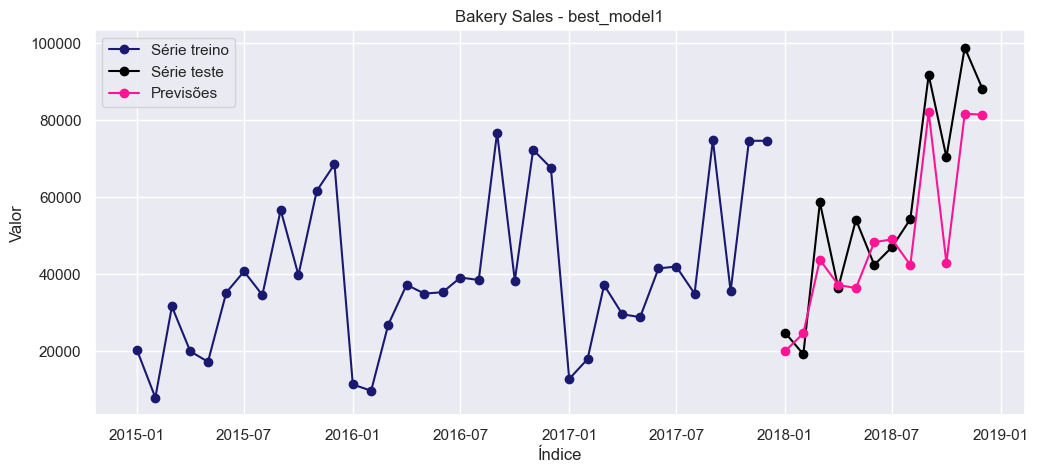

In [38]:
# Plotando previsões best_model1
fig, ax = plt.subplots(figsize=(12,5))

plt.plot(df_bake_train, label='Série treino', color='midnightblue', marker='o')
plt.plot(df_bake_test, label='Série teste', color='black', marker='o')
plt.plot(fcast_bake_best_model, label='Previsões', color='deeppink', marker='o')

# Adicione legendas e títulos ao gráfico
plt.plot(marker='o')
ax.legend(loc='upper left')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Bakery Sales - best_model1')

# Mostre o gráfico
plt.show()

## Food Grains

In [39]:
## Preparação de base para treino e teste

# Filtrando categoria na base de treino
df_fg_train = X_train[['date','fg']]

# Filtrando categoria na base de teste
df_fg_test = X_test[['date','fg']]

# Configurando a coluna de data como index
df_fg_train.set_index('date', inplace=True)
df_fg_test.set_index('date', inplace=True)

In [40]:
#Encontrando melhor modelo auto_arima

auto_arima_model_fg = auto_arima(df_fg_train['fg'],
                               seasonal = True,
                                m = 12,
                               start_p = 0, 
                               d = 1, 
                               start_q = 0,
                               max_p = 3,
                               max_q = 3,
                                D = 1,
                                start_P = 0,
                                start_Q = 0,
                                max_P = 3,
                                max_Q = 3,
                                information_criterion = 'aic',
                                error_action = 'warn',
                                trace = True,
                                suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=522.960, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=510.792, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=511.931, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=513.938, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=510.835, Time=0.17 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=511.445, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=511.604, Time=0.10 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=512.832, Time=0.33 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=517.870, Time=0.07 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=512.772, Time=0.11 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=510.968, Time=0.21 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=510.907, Time=0.16 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=513.234, Time=0.10 sec

Best model:  ARIMA(1,1,0)(1,1,0)[12]

In [41]:
# Rodando ARIMA com base em melhor modelo pelo auto_arima
model_auto_arima_fg = SARIMAX(df_fg_train, order=auto_arima_model_fg.order, seasonal_order = auto_arima_model_fg.seasonal_order)
model_auto_arima_fit_fg = model_auto_arima_fg.fit()

# Salvando predições ARIMA
fcast_fg_arima = model_auto_arima_fit_fg.forecast(period_test-1)

fcast_fg_auto_arima = pd.Series(fcast_fg_arima.values, index=index_dates)

fcast_fg_auto_arima = pd.Series(fcast_fg_arima.values, index=index_dates)
fcast_fg_auto_arima = fcast_fg_auto_arima.rename("fcst_auto_arima")

rmse_auto_arima_fg = np.sqrt(mean_squared_error(df_fg_test['fg'], fcast_fg_auto_arima))
mape_auto_arima_fg = mean_absolute_percentage_error(df_fg_test['fg'], fcast_fg_auto_arima)*100
resid_mean_auto_arima_fg = model_auto_arima_fit_fg.resid.mean()

print(rmse_auto_arima_fg)
print(mape_auto_arima_fg)
print(resid_mean_auto_arima_fg)

19738.05285406358
39.54229356225253
1079.9470646536267


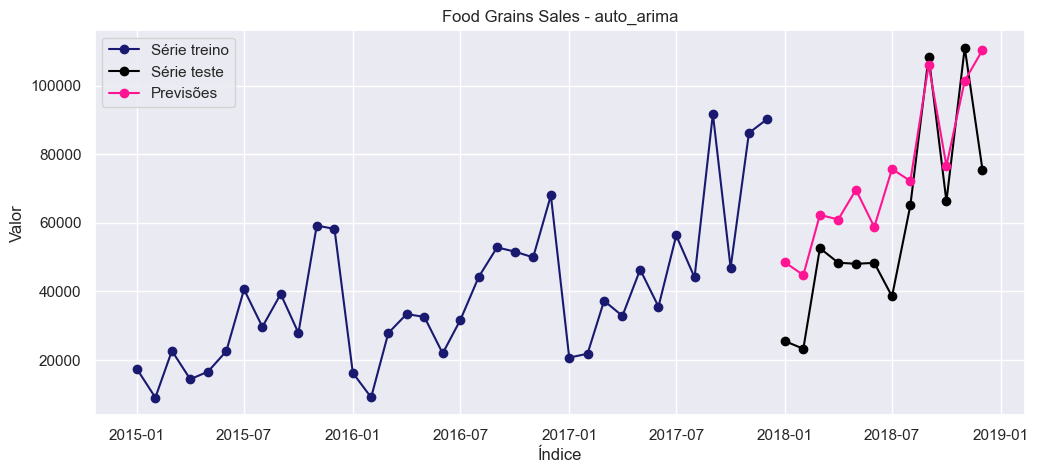

In [42]:
# Plotando previsões auto-arima
fig, ax = plt.subplots(figsize=(12,5))

plt.plot(df_fg_train, label='Série treino', color='midnightblue', marker='o')
plt.plot(df_fg_test, label='Série teste', color='black', marker='o')
plt.plot(fcast_fg_auto_arima, label='Previsões', color='deeppink', marker='o')

# Adicione legendas e títulos ao gráfico
plt.plot(marker='o')
ax.legend(loc='upper left')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Food Grains Sales - auto_arima')

# Mostre o gráfico
plt.show()

In [43]:
#Função para encontrar o modelo ARIMA

def evaluate_arima_model(df, order, seasonal_order):

    model = SARIMAX(df, order=order, seasonal_order=seasonal_order)
    results = model.fit()

    # Calcula algumas métricas de avaliação do modelo
    aic = results.aic
    resid_mean = results.resid.mean()

    return {'order': order, 'seasonal_order': seasonal_order, 'aic': aic, 'resid_mean': resid_mean}


def evaluate_models_fg(df, seasonal=True):

    # Define as listas de parâmetros para a busca
    p = range(0, 3)
    d = range(1, 2)
    q = range(0, 3)
    P = range(0, 3)
    D = range(1, 2)
    Q = range(0, 3)
    m = range(12,13)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq  = list(itertools.product(P, D, Q,m))    

    all_models = []

    # Itera por todas as combinações de parâmetros
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            model_params = evaluate_arima_model(df, param, param_seasonal)
            if model_params:
                all_models.append(model_params)

    # Converte a lista de resultados em um DataFrame pandas
    all_models_df = pd.DataFrame(all_models)

    # Define o número de períodos de validação
    n_periods = 12

    # Calcula as métricas RMSE e MAPE para cada modelo
    rmse_list = []
    mape_list = []
    
    for i in range(len(all_models)):
        model = SARIMAX(df, order=all_models[i]['order'], seasonal_order=all_models[i]['seasonal_order'])
        results = model.fit()
        preds = results.forecast(steps=n_periods)
        rmse = np.sqrt(mean_squared_error(df_fg_test['fg'], preds))
        mape = mean_absolute_percentage_error(df_fg_test['fg'], preds)*100
        rmse_list.append(rmse)
        mape_list.append(mape)

    # Adiciona as colunas de RMSE e MAPE ao DataFrame
    all_models_df['rmse'] = rmse_list
    all_models_df['mape'] = mape_list

    # Retorna o DataFrame com os resultados de todos os modelos avaliados
    return all_models_df

In [44]:
# Chama a função evaluate_models para obter uma tabela com todos os modelos avaliados
df_models_fg = evaluate_models_fg(df_fg_train, seasonal=True)

df_models_fg = df_models_fg.sort_values(['mape', 'aic'])

In [45]:
#Filtrando melhores modelos

df_models_index_fg = df_models_fg.reset_index()

query_fg = [70]

df_models_filtered_fg = df_models_index_fg[df_models_index_fg['index'].isin(query_fg)]

df_models_filtered_fg = df_models_filtered_fg.reset_index()

df_models_filtered_fg

,level_0,index,order,seasonal_order,aic,resid_mean,rmse,mape
0,0,70,"(2, 1, 1)","(2, 1, 1, 12)",512.816661,-167.889873,12968.893737,14.801741


In [46]:
#Salvando parâmetros dos melhores modelos selecionados

order_model_fg = df_models_filtered_fg['order'].loc[0]
seasonal_order_model_fg = df_models_filtered_fg['seasonal_order'].loc[0]

In [47]:
# Rodando ARIMA com base em melhor modelo pela função best_model 1

model_best_model_fg = SARIMAX(df_fg_train, order=order_model_fg, seasonal_order = seasonal_order_model_fg)
model_best_model_fit_fg = model_best_model_fg.fit()

# Salvando predições ARIMA
fcast_fg_best_model = model_best_model_fit_fg.forecast(period_test-1)

fcast_fg_best_model = pd.Series(fcast_fg_best_model.values, index=index_dates)

fcast_fg_best_model = pd.Series(fcast_fg_best_model.values, index=index_dates)
fcast_fg_best_model = fcast_fg_best_model.rename("fcst_best_model")

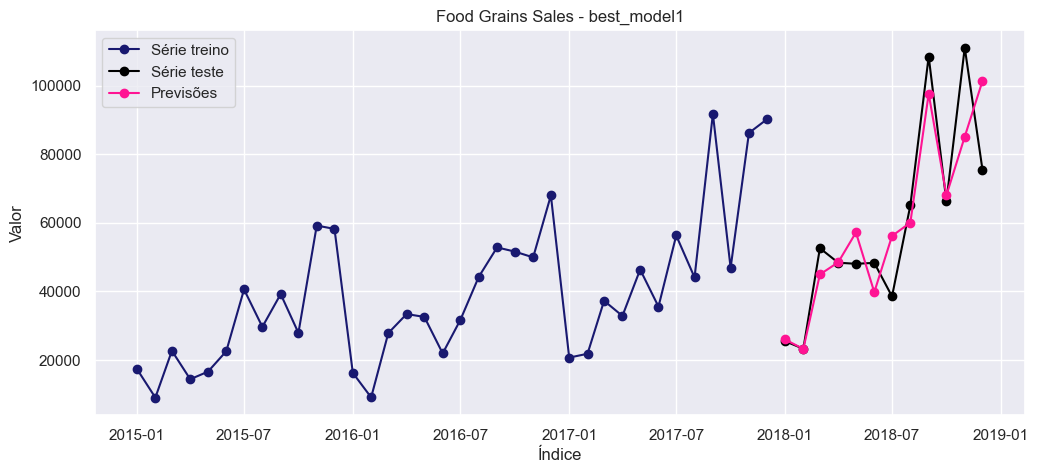

In [48]:
# Plotando previsões best_model1
fig, ax = plt.subplots(figsize=(12,5))

plt.plot(df_fg_train, label='Série treino', color='midnightblue', marker='o')
plt.plot(df_fg_test, label='Série teste', color='black', marker='o')
plt.plot(fcast_fg_best_model, label='Previsões', color='deeppink', marker='o')

# Adicione legendas e títulos ao gráfico
plt.plot(marker='o')
ax.legend(loc='upper left')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Food Grains Sales - best_model1')

# Mostre o gráfico
plt.show()

# 8. Resultados

In [49]:
#Preparando range de período para previsões

from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta

start_date = datetime(2019, 1, 1)
end_date = datetime(2020, 1, 1)

date_range = end_date.year - start_date.year
months = [start_date + relativedelta(months=x) for x in range(date_range*11 + 1)]


In [50]:
# Forecast de 2019

df_sum_model = df_sum[['date','total']]
df_sum_model.set_index('date', inplace=True)

# Rodando ARIMA com base em melhor modelo pela função best_model 1

model_best_model_total1_fcst = SARIMAX(df_sum_model, order=order_model1, seasonal_order = seasonal_order_model1)
model_best_model_fit_total1_fcst = model_best_model_total1_fcst.fit()

# Salvando predições ARIMA
fcast_total_best_model1_fcst = model_best_model_fit_total1_fcst.forecast(steps=12)

fcast_total_best_model1_fcst = pd.Series(fcast_total_best_model1_fcst.values, index=months)

fcast_total_best_model1_fcst = fcast_total_best_model1_fcst.rename("total")


In [51]:
#Configurando o intervalo de previsão

pred = model_best_model_fit_total1_fcst.get_prediction(start='2019-01-01', end='2019-12-01', dynamic=False)
forecast = pred.predicted_mean
pred_int = pred.conf_int(alpha=0.05)

pred_int = pred_int.round({'upper total': 2})
pred_int = pred_int.round({'lower total': 2})

pred_int['forecast'] = forecast.round(2)


pred_int['prox_lower'] = abs(( pred_int['forecast'] - pred_int['lower total'])/pred_int['lower total'] )

pred_int['prox_upper'] = abs(( pred_int['forecast'] - pred_int['upper total'])/pred_int['upper total'] )

pred_int.to_excel('G:/Meu Drive/MBA USPEsalq/TCC/07.Trabalho Final/intervalo de previsao.xlsx', index=True)

pred_int

,lower total,upper total,forecast,prox_lower,prox_upper
2019-01-01,325332.18,486613.68,405972.93,0.247872,0.165718
2019-02-01,228584.71,429511.98,329048.35,0.439503,0.233902
2019-03-01,406536.51,654258.17,530397.34,0.304673,0.189315
2019-04-01,331330.48,610645.07,470987.77,0.421505,0.228705
2019-05-01,387041.00,699351.03,543196.02,0.403459,0.223286
2019-06-01,345607.77,684645.95,515126.86,0.490496,0.247601
2019-07-01,330181.59,696260.15,513220.87,0.554359,0.262889
2019-08-01,296324.58,685767.85,491046.22,0.657123,0.283947
2019-09-01,675403.67,1088429.40,881916.53,0.305762,0.189735
2019-10-01,386891.04,820849.59,603870.31,0.560828,0.264335


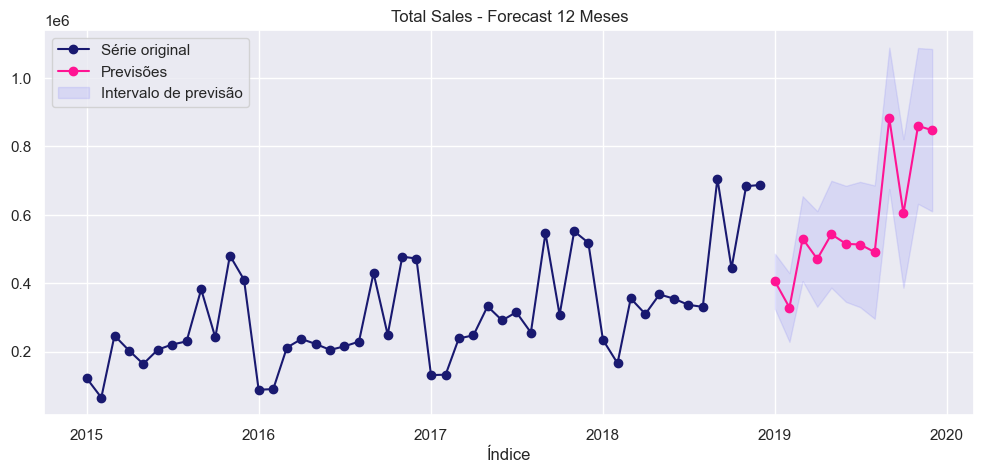

In [53]:
# Plotando previsões

forecast_index = fcast_total_best_model1_fcst.index

fig, ax = plt.subplots(figsize=(12,5))


plt.plot(df_sum_model, label='Série original', color='midnightblue', marker='o')
plt.plot(fcast_total_best_model1_fcst, label='Previsões', color='deeppink', marker='o')

# Adicione o intervalo de tolerância ao gráfico
plt.fill_between(forecast_index, pred_int.iloc[:, 0], pred_int.iloc[:, 1], alpha=0.08, color='blue', label='Intervalo de previsão')


# Adicione legendas e títulos ao gráfico
plt.plot(marker='o')
ax.legend(loc='upper left')
plt.xlabel('Índice')
plt.title('Total Sales - Forecast 12 Meses')

# Mostre o gráfico
plt.show()